In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import *
from sklearn.model_selection import *
from sklearn.svm import *
from sklearn.feature_selection import *
from sklearn.feature_extraction import *
from sklearn.naive_bayes import *
import xgboost
from scipy.sparse import *
from sklearn.decomposition import *
from sklearn.neural_network import *


%matplotlib inline

In [2]:
data = np.loadtxt('training_data.txt', skiprows=1)
y = data[:,0]
X = data[:,1:]

In [3]:
Xtest = np.loadtxt('test_data.txt', skiprows=1)

In [4]:
Xvecsum = np.sum(X, axis=1)

Tfid = text.TfidfTransformer(norm='l2')
Tfid.fit(X, y)
TfidXsparse = Tfid.transform(X)
TfidXtest = Tfid.transform(Xtest)
TfidX = np.asarray(csr_matrix.todense(TfidXsparse))
TfidXtest = np.asarray(csr_matrix.todense(TfidXtest))
temp_arr = []
for i in range(0, len(TfidX)):
    temp_arr.append(np.append(TfidX[i], Xvecsum[i]))
TfidX_sum = np.array(temp_arr)

In [5]:
svd = TruncatedSVD(n_components=100, algorithm='arpack')
sv_tfidX = svd.fit_transform(TfidX)
sv_tfidXtest = svd.transform(TfidXtest)

In [6]:
sv_tfidXtest.shape

(10000, 100)

In [7]:
binX = []
for i in range(0, len(X)):
    binX.append(X[i] > 0)
binX = np.array(binX)

In [8]:
vocab_count = np.sum(X, axis=0)

In [9]:
Xvecsum = np.sum(X, axis=1)
Xcomb = []

for i in range(0, len(X)):
    temp_arr = np.concatenate((TfidX[i], sv_tfidX[i]))
    temp_arr = np.append(temp_arr, Xvecsum[i])
    Xcomb.append(temp_arr)
Xcomb = np.array(Xcomb)


In [10]:
Xvecsumtest = np.sum(Xtest, axis=1)
Xcombtest = []

for i in range(0, len(Xtest)):
    temp_arr = np.concatenate((TfidXtest[i], sv_tfidXtest[i]))
    temp_arr = np.append(temp_arr, Xvecsumtest[i])
    Xcombtest.append(temp_arr)
Xcombtest = np.array(Xcombtest)

In [11]:
Xcomb.shape

(20000, 1101)

### Making figs

In [45]:
rbf_svm = SVC(C=1.5, gamma=0.015)    
svd_clf = SVC(C=50, gamma=0.2)
nn = KerasClassifier(build_fn=create_baseline(Xcomb.shape[1]), epochs=10, batch_size=20, verbose=0)
xg_lin = xgboost.XGBClassifier(booster='gblinear', reg_lambda=0, eval_metric='error')

In [41]:
kfold = StratifiedKFold(n_splits=4, shuffle=True)
rbf_svm_cv = cross_val_score(rbf_svm, X, y, cv=kfold, n_jobs=-1)

In [42]:
svd_clf_cv = cross_val_score(svd_clf, sv_tfidX, y, cv=kfold, n_jobs=-1)

In [47]:
estimator = KerasClassifier(build_fn=create_baseline(Xcomb.shape[1]), epochs=10, batch_size=20, verbose=0)
kfold = StratifiedKFold(n_splits=4, shuffle=True)
results = cross_val_score(estimator, Xcomb, y, cv=kfold)

In [48]:
nn_cv = results

In [49]:
xg_lin_cv = cross_val_score(xg_lin, TfidX, y, cv=kfold, n_jobs=-1)

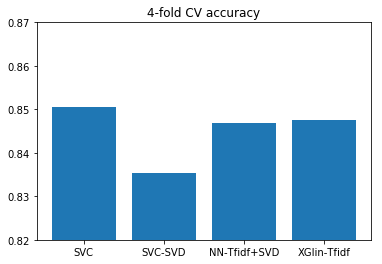

In [58]:
cv_res = [rbf_svm_cv, svd_clf_cv, nn_cv, xg_lin_cv]
cv_res = np.mean(cv_res, axis=1)
plt.bar(np.arange(0, 4), cv_res)
plt.ylim(0.82, 0.87)
plt.title('4-fold CV accuracy')
plt.xticks(np.arange(0, 4), ['SVC', 'SVC-SVD', 'NN-Tfidf+SVD', 'XGlin-Tfidf'])
plt.savefig('Cross-val accuracy', dpi=399)

In [60]:
def gen_TfidX(X):
    Tfid = text.TfidfTransformer(norm='l2')
    Tfid.fit(X)
    TfidXsparse = Tfid.transform(X)
    TfidX = np.asarray(csr_matrix.todense(TfidXsparse))
    return TfidX

def gen_svX(X):
    TfidX = gen_TfidX(X)
    svd = TruncatedSVD(n_components=100, algorithm='arpack')
    sv_tfidX = svd.fit_transform(TfidX)
    return sv_tfidX

def gen_combX(X, TfidX, svX):
    Xvecsum = np.sum(X, axis=1)
    Xcomb = []

    for i in range(0, len(X)):
        temp_arr = np.concatenate((TfidX[i], svX[i]))
        temp_arr = np.append(temp_arr, Xvecsum[i])
        Xcomb.append(temp_arr)
    Xcomb = np.array(Xcomb)
    return Xcomb

In [62]:
X1 = X
y1 = y
X2 = Xtest

TfidX1 = gen_TfidX(X1)
svX1 = gen_svX(X1)
combX1 = gen_combX(X1, TfidX1, svX1)
TfidX2 = gen_TfidX(X2)
svX2 = gen_svX(X2)
combX2 = gen_combX(X2, TfidX2, svX2)

rbf_svm = SVC(C=1.5, gamma=0.015)    
svd_clf = SVC(C=50, gamma=0.2)
nn = create_baseline(combX1.shape[1])()    
xg_lin = xgboost.XGBClassifier(booster='gblinear', reg_lambda=0, eval_metric='error')

rbf_svm.fit(X1, y1)
svd_clf.fit(svX1, y1)
nn.fit(combX1, y1, epochs=30, batch_size=20, verbose=False)
xg_lin.fit(TfidX1, y1)

rbf_svm_pred = rbf_svm.predict(X2)
svd_clf_pred = svd_clf.predict(svX2)
nn_pred_sig = nn.predict(combX2)
nn_pred = np.round(nn_pred_sig)[:,0]
xg_lin_pred = xg_lin.predict(TfidX2)

preds = [rbf_svm_pred, svd_clf_pred, nn_pred, xg_lin_pred]
preds = np.array(preds)

In [66]:
corrmat = []
for i in range(0,4):
    tmp = []
    for j in range(0,4):
        tmp.append(np.mean(preds[i]==preds[j]))
    corrmat.append(np.array(tmp))

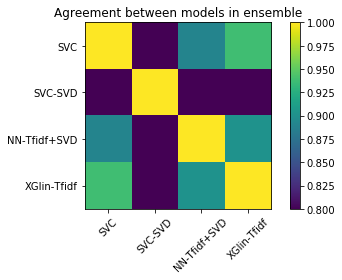

In [78]:
plt.imshow(corrmat, vmin=0.8)
plt.colorbar()
plt.xticks(range(0,4), ['SVC', 'SVC-SVD', 'NN-Tfidf+SVD', 'XGlin-Tfidf'], rotation=45)
plt.yticks(range(0,4), ['SVC', 'SVC-SVD', 'NN-Tfidf+SVD', 'XGlin-Tfidf'])
plt.title('Agreement between models in ensemble')
plt.tight_layout()
plt.savefig('ModelAgreement.png', dpi=399)

### Regularized logistic regression

In [13]:
def fit_lr(X, y):
    lr_clf = LogisticRegressionCV()
    lr_clf.fit(X, y)
    best_C = lr_clf.C_[0]

    lr_clf = LogisticRegression(C=best_C)
    kfold = StratifiedKFold(n_splits=5, shuffle=True)
    scores = cross_val_score(lr_clf, X, y, cv=kfold)
    return np.mean(scores)

In [14]:
fit_lr(Xcomb, y)

0.85040025508439088

### Non-linear-SVM

In [15]:
gammas = np.array([0.1, 1, 10])/len(X[0])

In [16]:
for gamma in gammas:
    clf = SVC(gamma=gamma)
    kfold = StratifiedKFold(n_splits=4, shuffle=True)
    results = cross_val_score(clf, X, y, cv=kfold, n_jobs=-1)
    print('gamma of {} gives error of {}'.format(gamma, results.mean()))

gamma of 0.0001 gives error of 0.7327497146399886
gamma of 0.001 gives error of 0.8306000966480038
gamma of 0.01 gives error of 0.8483996969279879


In [17]:
for gamma in np.array([20, 50, 100])/len(X[0]):
    clf = SVC(gamma=gamma)
    kfold = StratifiedKFold(n_splits=4, shuffle=True)
    results = cross_val_score(clf, X, y, cv=kfold, n_jobs=-1)
    print('gamma of {} gives error of {}'.format(gamma, results.mean()))

gamma of 0.02 gives error of 0.8501500569280023
gamma of 0.05 gives error of 0.8145998063379923


KeyboardInterrupt: 

In [ ]:
for C in [0.5, 1.5]:
    for gamma in np.array([15, 30])/len(X[0]):
        clf = SVC(C=C, gamma=gamma)
        kfold = StratifiedKFold(n_splits=4, shuffle=True)
        results = cross_val_score(clf, X, y, cv=kfold, n_jobs=-1)
        print('C of {} and gamma of {} gives error of {}'.format(C, gamma, results.mean()))

In [ ]:
for C in [1.5, 2]:
    for gamma in np.array([10, 20])/len(X[0]):
        clf = SVC(C=C, gamma=gamma)
        kfold = StratifiedKFold(n_splits=4, shuffle=True)
        results = cross_val_score(clf, X, y, cv=kfold, n_jobs=-1)
        print('C of {} and gamma of {} gives error of {}'.format(C, gamma, results.mean()))

In [18]:
clf = SVC(C=1.5, gamma=0.015)
clf.fit(X, y)

SVC(C=1.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.015, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [20]:
rbfsvmX = clf

In [19]:
SVM_pred = clf.predict(Xtest)

In [ ]:
def make_pred_df(test_pred):
    preds = []
    for pred in test_pred:
        preds.append(int(pred))
    out_df = pd.DataFrame({'Prediction':preds})
    out_df.index += 1
    return out_df

In [ ]:
out_df = make_pred_df(SVM_pred)
out_df.to_csv('RBF_SVM_X1.txt', index_label='Id')

### SVD only

In [ ]:
for C in [0.1, 1, 10]:
    for gamma in np.array([0.1, 1, 10])/len(sv_tfidX[0]):
        clf = SVC(C=C, gamma=gamma)
        kfold = StratifiedKFold(n_splits=4, shuffle=True)
        results = cross_val_score(clf, sv_tfidX, y, cv=kfold, n_jobs=-1)
        print('C of {} and gamma of {} gives error of {}'.format(C, gamma, results.mean()))

In [ ]:
for C in [10, 20]:
    for gamma in np.array([1, 5, 20])/len(sv_tfidX[0]):
        clf = SVC(C=C, gamma=gamma)
        kfold = StratifiedKFold(n_splits=4, shuffle=True)
        results = cross_val_score(clf, sv_tfidX, y, cv=kfold, n_jobs=-1)
        print('C of {} and gamma of {} gives error of {}'.format(C, gamma, results.mean()))

In [ ]:
for C in [30, 50]:
    for gamma in np.array([20, 35, 50])/len(sv_tfidX[0]):
        clf = SVC(C=C, gamma=gamma)
        kfold = StratifiedKFold(n_splits=4, shuffle=True)
        results = cross_val_score(clf, sv_tfidX, y, cv=kfold, n_jobs=-1)
        print('C of {} and gamma of {} gives error of {}'.format(C, gamma, results.mean()))

In [21]:
svd_clf = SVC(C=50, gamma=0.2)
svd_clf.fit(sv_tfidX, y)

SVC(C=50, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.2, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Ensemble Methods

In [ ]:
sv_pred = svd_clf.predict(sv_tfidXtest)

In [ ]:
np.mean(sv_pred == SVM_pred)

In [ ]:
np.mean(SVM_pred == xglin_pred)

In [ ]:
xgtree_pred = xg_tree.predict(TfidXtest)
mn_bayes_pred = mn_bayes.predict(TfidXtest)

In [ ]:
preds = [SVM_pred, sv_pred, nn_pred, xglin_pred, mn_bayes_pred, xgtree_pred]
corr_mat = []
for i in range(0, len(preds)):
    tmp = []
    for j in range(0, len(preds)):
        tmp.append(np.mean(preds[i] == preds[j]))
    corr_mat.append(np.array(tmp))
corr_mat = np.array(corr_mat)

In [ ]:
plt.imshow(corr_mat, vmin=0.8, vmax=1)
plt.colorbar()

In [ ]:
med_ens = np.median(preds, axis=0)

In [ ]:
out_df = make_pred_df(med_ens)
out_df.to_csv('6method_ens.txt', index_label='Id')

In [ ]:
for i in range(0, 20):
    

### TFID Normalized

In [ ]:
for C in [0.01, 0.1, 1, 10, 100]:
    for gamma in np.array([50, 100, 500, 1000])/len(TfidX_sum[0]):
        clf = SVC(C=C, gamma=gamma)
        kfold = StratifiedKFold(n_splits=4, shuffle=True)
        results = cross_val_score(clf, TfidX_sum, y, cv=kfold, n_jobs=-1)
        print('C of {} and gamma of {} gives error of {}'.format(C, gamma, results.mean()))

In [ ]:
for C in [5, 10, 20]:
    for gamma in np.array([1, 10])/len(TfidX_sum[0]):
        clf = SVC(C=C, gamma=gamma)
        kfold = StratifiedKFold(n_splits=4, shuffle=True)
        results = cross_val_score(clf, TfidX_sum, y, cv=kfold, n_jobs=-1)
        print('C of {} and gamma of {} gives error of {}'.format(C, gamma, results.mean()))

In [ ]:
for C in [30]:
    for gamma in np.array([10])/len(TfidX_sum[0]):
        clf = SVC(C=C, gamma=gamma)
        kfold = StratifiedKFold(n_splits=4, shuffle=True)
        results = cross_val_score(clf, TfidX_sum, y, cv=kfold, n_jobs=-1)
        print('C of {} and gamma of {} gives error of {}'.format(C, gamma, results.mean()))

In [ ]:
for C in [25]:
    for gamma in np.array([8, 15, 30])/len(TfidX_sum[0]):
        clf = SVC(C=C, gamma=gamma)
        kfold = StratifiedKFold(n_splits=4, shuffle=True)
        results = cross_val_score(clf, TfidX_sum, y, cv=kfold, n_jobs=-1)
        print('C of {} and gamma of {} gives error of {}'.format(C, gamma, results.mean()))

### Xcomb

In [ ]:
for C in [0.01, 0.1, 1, 10, 100]:
    for gamma in np.array([1, 10, 100, 500, 1000])/len(Xcomb[0]):
        clf = SVC(C=C, gamma=gamma)
        kfold = StratifiedKFold(n_splits=4, shuffle=True)
        results = cross_val_score(clf, Xcomb, y, cv=kfold, n_jobs=-1)
        print('C of {} and gamma of {} gives error of {}'.format(C, gamma, results.mean()))

In [ ]:
for C in [5, 15, 30]:
    for gamma in np.array([10, 100])/len(Xcomb[0]):
        clf = SVC(C=C, gamma=gamma)
        kfold = StratifiedKFold(n_splits=4, shuffle=True)
        results = cross_val_score(clf, Xcomb, y, cv=kfold, n_jobs=-1)
        print('C of {} and gamma of {} gives error of {}'.format(C, gamma, results.mean()))

In [ ]:
for C in [20, 50]:
    for gamma in np.array([5, 10])/len(Xcomb[0]):
        clf = SVC(C=C, gamma=gamma)
        kfold = StratifiedKFold(n_splits=4, shuffle=True)
        results = cross_val_score(clf, Xcomb, y, cv=kfold, n_jobs=-1)
        print('C of {} and gamma of {} gives error of {}'.format(C, gamma, results.mean()))

In [ ]:
for C in [50, 100]:
    for gamma in np.array([5])/len(Xcomb[0]):
        clf = SVC(C=C, gamma=gamma)
        kfold = StratifiedKFold(n_splits=4, shuffle=True)
        results = cross_val_score(clf, Xcomb, y, cv=kfold, n_jobs=-1)
        print('C of {} and gamma of {} gives error of {}'.format(C, gamma, results.mean()))

In [ ]:
for C in [35, 50, 65]:
    for gamma in np.array([1])/len(Xcomb[0]):
        clf = SVC(C=C, gamma=gamma)
        kfold = StratifiedKFold(n_splits=4, shuffle=True)
        results = cross_val_score(clf, Xcomb, y, cv=kfold, n_jobs=-1)
        print('C of {} and gamma of {} gives error of {}'.format(C, gamma, results.mean()))

In [ ]:
for C in [60, 70, 80]:
    for gamma in np.array([0.75, 1, 1.25])/len(Xcomb[0]):
        clf = SVC(C=C, gamma=gamma)
        kfold = StratifiedKFold(n_splits=4, shuffle=True)
        results = cross_val_score(clf, Xcomb, y, cv=kfold, n_jobs=-1)
        print('C of {} and gamma of {} gives error of {}'.format(C, gamma, results.mean()))

In [ ]:
for C in [78, 85, 90]:
    for gamma in np.array([1.2, 1.3, 1.5])/len(Xcomb[0]):
        clf = SVC(C=C, gamma=gamma)
        kfold = StratifiedKFold(n_splits=4, shuffle=True)
        results = cross_val_score(clf, Xcomb, y, cv=kfold, n_jobs=-1)
        print('C of {} and gamma of {} gives error of {}'.format(C, gamma, results.mean()))

### Polynomial SVM results

In [ ]:
pn_svm = pd.read_csv('X_scan1.csv')

In [ ]:
pn_svm[pn_svm['mean_test_score'] > 0.845]

In [ ]:
pn_svm2 = pd.read_csv('X_scan2.csv')

In [ ]:
pn_svm2[pn_svm2['mean_test_score'] > 0.845]

### Linear-SVM

In [ ]:
def linear_svmfit(X, y):
    svc_params = {'C': np.logspace(-4, 4, 7)}
    svc = LinearSVC(dual=False)
    search_clf = GridSearchCV(svc, svc_params)
    search_clf.fit(X, y)
    clf = search_clf.best_estimator_
    kfold = StratifiedKFold(n_splits=5, shuffle=True)
    scores = cross_val_score(clf, X, y, cv=kfold)
    return np.mean(scores)

In [ ]:
linear_svmfit(binX, y)

In [ ]:
linear_svmfit(TfidX, y)

### Neural-net

In [22]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [23]:
def create_baseline(input_N):
    def build_fn():
        do = 0.05
        model = Sequential()
        model.add(Dense(100, input_dim=input_N, kernel_initializer='normal', activation='relu'))
        model.add(Dropout(do))
        model.add(Dense(30, activation='relu'))
        model.add(Dropout(do))
        model.add(Dense(30, activation='relu'))
        model.add(Dropout(do))
        model.add(Dense(30, activation='relu'))
        model.add(Dropout(do))


        model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
        # Compile model
        model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
        return model
    return build_fn

In [24]:
def test_NN(X, y):
    estimator = KerasClassifier(build_fn=create_baseline(X.shape[1]), epochs=10, batch_size=20, verbose=0)
    kfold = StratifiedKFold(n_splits=4, shuffle=True)
    results = cross_val_score(estimator, X, y, cv=kfold)
    return results.mean()

In [25]:
test_NN(Xcomb,y) #100,30,30 0.05

0.84939986667723533

In [26]:
test_NN(Xcomb,y) #100,30,30,30 0.05

0.8462994988061775

In [27]:
nn = create_baseline(Xcomb.shape[1])()
nn.fit(Xcomb, y, epochs=30)

Epoch 1/30
20000/20000 [==============================] - 3s 146us/step - loss: 0.5111 - acc: 0.7459
Epoch 2/30
20000/20000 [==============================] - 2s 122us/step - loss: 0.3596 - acc: 0.8442
Epoch 3/30
20000/20000 [==============================] - 2s 118us/step - loss: 0.3334 - acc: 0.8577
Epoch 4/30
20000/20000 [==============================] - 2s 106us/step - loss: 0.3225 - acc: 0.8618
Epoch 5/30
20000/20000 [==============================] - 2s 113us/step - loss: 0.3148 - acc: 0.8651
Epoch 6/30
20000/20000 [==============================] - 2s 115us/step - loss: 0.3093 - acc: 0.8661
Epoch 7/30
20000/20000 [==============================] - 2s 111us/step - loss: 0.3032 - acc: 0.8709
Epoch 8/30
20000/20000 [==============================] - 2s 117us/step - loss: 0.2992 - acc: 0.8729
Epoch 9/30
20000/20000 [==============================] - 2s 118us/step - loss: 0.2942 - acc: 0.8752
Epoch 10/30
20000/20000 [==============================] - 2s 113us/step - loss: 0.2920 - a

In [28]:
nn_predsig = nn.predict(Xcombtest)
nn_pred = np.round(nn_predsig)[:,0]

### Gradient boosted trees

In [29]:
xg_tree = xgboost.XGBClassifier(max_depth=5, objective='binary:logistic', eta=0.6)
kfold = StratifiedKFold(n_splits=4, shuffle=True)
scores = cross_val_score(xg_tree, TfidX, y, cv=kfold, n_jobs=-1)
scores.mean()

0.80930025608401024

In [30]:
xg_tree.fit(TfidX, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.6, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

### Gradient boosted linear

In [31]:
xg_model = xgboost.XGBClassifier(booster='gblinear', reg_lambda=0, eval_metric='error')
kfold = StratifiedKFold(n_splits=5, shuffle=True)
scores = cross_val_score(xg_model, TfidX_sum, y, cv=kfold)
scores.mean()

0.84455029219376831

In [32]:
xg_model.fit(TfidX, y)

XGBClassifier(base_score=0.5, booster='gblinear', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='error', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=0, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [33]:
xglin_pred = xg_model.predict(TfidXtest)

In [34]:
xgtree = xgboost.XGBClassifier()
xgtree.fit(TfidX, y)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
scores = cross_val_score(xgtree, TfidX, y, cv=kfold)

In [ ]:
scores.mean()

In [ ]:
xg_model = xgboost.XGBClassifier(booster='gblinear', reg_lambda=0, 'objective':'binary:logistic')
xg_model.fit(TfidX, y)
test_pred = xg_model.predict(TfidXtest)

In [ ]:
def make_pred_df(test_pred):
    preds = []
    for pred in test_pred:
        preds.append(int(pred))
    out_df = pd.DataFrame({'Prediction':preds})
    out_df.index += 1
    return out_df

In [ ]:
out_df = make_pred_df(test_pred)
out_df.to_csv('XGlinear_Tfid_01.txt', index_label='Id')

### Naive Bayes

In [35]:
mn_bayes = MultinomialNB(alpha=0.5)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
scores = cross_val_score(mn_bayes, TfidX, y, cv=kfold)
scores.mean()

0.82964999154374952

In [36]:
mn_bayes = MultinomialNB()
mn_bayes.fit(TfidX, y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

### Restricted boltzmann machine

### Ensemble models (not worth it?)

In [ ]:
X1, X2, y1, y2 = train_test_split(X, y, test_size=0.25)
partial_Tfid = text.TfidfTransformer()
partial_Tfid.fit(X1, y1)
tfX1 = partial_Tfid.transform(X1)
tfX2 = partial_Tfid.transform(X2)
svd = TruncatedSVD(n_components=100, algorithm='arpack')
svX1 = svd.fit_transform(tfX1)
svX2 = svd.fit_transform(tfX2)

In [ ]:
nn = Sequential()
nn.add(Dense(100, input_dim=tfX1.shape[1], kernel_initializer='normal', activation='relu'))
nn.add(Dropout(0.2))
nn.add(Dense(30, activation='relu'))
nn.add(Dropout(0.2))

nn.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
# Compile model
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
nn.fit(tfX1, y1, epochs=10, batch_size=20, verbose=0)

In [ ]:
nn.evaluate(tfX2, y2)

In [ ]:
nn_notfid = Sequential()
nn_notfid.add(Dense(100, input_dim=X1.shape[1], kernel_initializer='normal', activation='relu'))
nn_notfid.add(Dropout(0.2))
nn_notfid.add(Dense(30, activation='relu'))
nn_notfid.add(Dropout(0.2))

nn_notfid.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
# Compile model
nn_notfid.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
nn_notfid.fit(X1, y1, epochs=10, batch_size=20, verbose=0)

In [ ]:
nn_notfid.evaluate(X2, y2)

In [ ]:
nn_sv = Sequential()
nn_sv.add(Dense(60, input_dim=svX1.shape[1], kernel_initializer='normal', activation='relu'))
nn_sv.add(Dropout(0.1))

nn_sv.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
# Compile model
nn_sv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
nn_sv.fit(svX1, y1, epochs=10, batch_size=20, verbose=0)

In [ ]:
nn_sv.evaluate(svX2, y2)

In [ ]:
xg_model = xgboost.XGBClassifier()
xg_model.fit(svX1, y1)

In [ ]:
xg_model.score(svX2, y2)

In [ ]:
nn_pred = np.round(nn.predict(tfX2))[:,0]
nn_notfid_pred = np.round(nn_notfid.predict(X2))[:,0]
nn_sv_pred = np.round(nn_sv.predict(sv_tfidX))[0]

In [ ]:
ens_X = [nn_pred, nn_notfid_pred, nn_sv_pred]
ens_X = np.array(ens_X).T

In [ ]:
np.mean(y2 == nn_sv_pred)

In [ ]:
ens_Xtest = [lr_predtest, nn_predtest, mn_predtest, xglin_predtest, xgtree_predtest, nn_notfid_predtest]
ens_Xtest = np.array(ens_Xtest).T

In [ ]:
test_pred = xgtree_ens.predict(ens_Xtest)

In [ ]:
out_df = make_pred_df(test_pred)
out_df.to_csv('Ensemble_01.txt', index_label='Id')